### E22 Pneumonia Discrimination

- 목표 
    - 의료 영상을 분석하는 방법을 이해한다. 
    - 딥러닝을 활용하여 폐렴의 유무를 판별하는 모델을 만든다. 

In [268]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [269]:
# 변수 설정
AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
BATCH_SIZE = 16
IMAGE_SIZE = [180, 180]
EPOCHS = 35

#### 1. 데이터 준비하기

In [270]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [271]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [272]:
COUNT_NORMAR = len([filename for filename in train_filenames if 'NORMAL' in filename])
print(f'Normal images count in training set: {str(COUNT_NORMAR)}')

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f'Pneumonia images count in training set: {str(COUNT_PNEUMONIA)}' )

Normal images count in training set: 1069
Pneumonia images count in training set: 3116


In [273]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [274]:
#tf.data 갯수 확인 
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {str(TRAIN_IMG_COUNT)}')

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validating images count: {str(VAL_IMG_COUNT)}')

Training images count: 4185
Validating images count: 1047


In [275]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [276]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [277]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [278]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [279]:
for image, label in train_ds.take(1):
    print(f'Image shape: {image.shape}')
    print(f'Label: {label}')

Image shape: (180, 180, 3)
Label: False


In [280]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- No Augmentation

In [281]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- With Augmentation

In [282]:
# def augment(image, label):
#     image = tf.image.random_flip_left_right(image)
#     return image, label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
    
#     ds = ds.map(augment, num_parallel_calls=2)
    
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
    
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

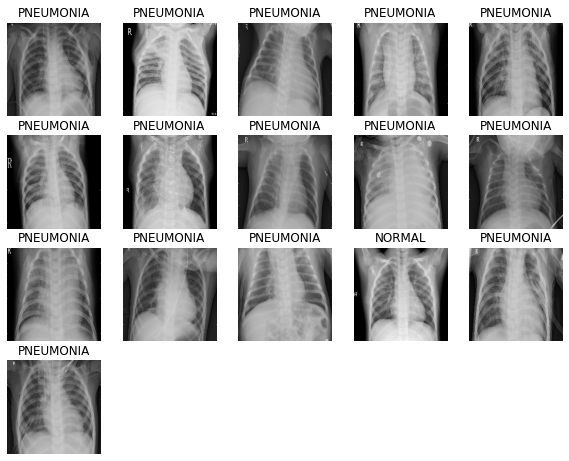

In [283]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')
        
show_batch(image_batch.numpy(), label_batch.numpy())

#### 2. 모델 만들기

In [284]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

In [285]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [286]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [287]:
weight_for_0 = (1 / COUNT_NORMAR) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1:weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


In [288]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### 3. 모델 학습

In [289]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds, 
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
261/261 [==============================] - 20s 78ms/step - loss: 0.3612 - accuracy: 0.8360 - precision: 0.9587 - recall: 0.8147 - val_loss: 0.7491 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 20s 77ms/step - loss: 0.2011 - accuracy: 0.9267 - precision: 0.9778 - recall: 0.9225 - val_loss: 1.1305 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 20s 77ms/step - loss: 0.1864 - accuracy: 0.9318 - precision: 0.9777 - recall: 0.9296 - val_loss: 0.3238 - val_accuracy: 0.8577 - val_precision: 0.8381 - val_recall: 0.9987
Epoch 4/35
261/261 [==============================] - 20s 77ms/step - loss: 0.1639 - accuracy: 0.9425 - precision: 0.9822 - recall: 0.9398 - val_loss: 0.2022 - val_accuracy: 0.9048 - val_precision: 0.8858 - val_recall: 0.9987
Epoch 5/35
261/261 [==============================] - 20s 78ms/step - loss: 0.1472 - accuracy: 0

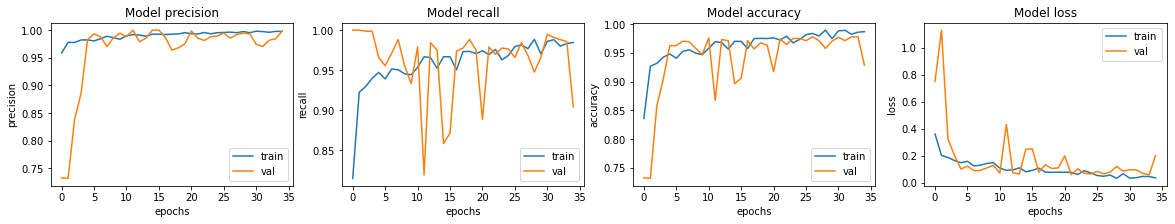

In [290]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 5. 결과

In [291]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 48ms/step - loss: 0.5807 - accuracy: 0.8590 - precision: 0.8447 - recall: 0.9487


- Augmentation으로 좌우 반전을 하였을 때 오히려 성능이 떨어지는 결과가 나왔다. 
- Epoch를 다양한게 조절하며 실험을 해본 결과 35번을 넘어가는 경우 오히려 Accuracy가 떨어져 성능이 좋지 않음을 확인할 수 있었다. 
- batch size를 변경하여보며 테스트를 한 경우 64로 설정하면 스텝이 작아지고 성능이 떨어져 값을 batch size 값을 32이하로 하는 것이 더 성능이 좋아지는 것을 확인할 수 있었다. 
- recall 값이 높은 것으로 보아 의료 영상을 판별하는데 적합한 결과가 나온것으로 생각할 수 있다. 

#### 6. 고찰 

- 영상 이미지의 경우 Augmentation 기법을 사용하는 경우 도메인 지식이 많지 않으면 쉽지 않다는 것을 알 수 있었다. 좌우 반전 정도의 Augmentation의 경우에는 성능의 변화가 없거나 더 좋아질 수도 있을 것이라고 예상하였지만 오히려 성능이 떨어지는 것을 보았을때 의료 이미지에 Augmentation을 할 때는 더 신중할 필요가 있을 것으로 보인다. 
- 기존에는 Imbalance 데이터의 경우 데이터의 양을 늘리거나 오히려 데이터 양을 줄이고 좀 더 단순한 네트워크를 쓰는 등의 방법을 활용하였는데 class weight를 다르게 주어 loss를 달리 계산하는 방법을 배울 수 있었다. 
- 예상보다 CNN 레이어 층을 깊게 쌓지 않아도 복잡하지 않은 네트워크 구조로도 괜찮은 성능을 확인할 수 있었다. 따라서 항상 복잡한 네트워크를 사용하는 것보다는 데이터와 목적에 따라 적절한 모델을 선정하는 것이 중요할 것으로 보인다. 